# Major Leagues

TODO Write intro

## Retrieving the Data
This data comes from the [FiveThirtyEight data on NBA scores](https://github.com/fivethirtyeight/data/tree/master/nba-elo). Note: this is not the _nba-carmelo_ link that was on the project desription, but that link does not go anywhere, so I will be using this instead - basketball is the only sport I actually understand (spoken like a true computer programmer). We will begin by loading the dataset into a dataframe:

In [1]:
from os import path
import numpy as np
import pandas as pd

nba_df = pd.read_csv("data/raw/nbaallelo.csv")
nba_df.head()

,gameorder,game_id,lg_id,_iscopy,year_id,date_game,seasongame,is_playoffs,team_id,fran_id,...,win_equiv,opp_id,opp_fran,opp_pts,opp_elo_i,opp_elo_n,game_location,game_result,forecast,notes
0,1,194611010TRH,NBA,0,1947,11/1/1946,1,0,TRH,Huskies,...,40.294830,NYK,Knicks,68,1300.0000,1306.7233,H,L,0.640065,NaN
1,1,194611010TRH,NBA,1,1947,11/1/1946,1,0,NYK,Knicks,...,41.705170,TRH,Huskies,66,1300.0000,1293.2767,A,W,0.359935,NaN
2,2,194611020CHS,NBA,0,1947,11/2/1946,1,0,CHS,Stags,...,42.012257,NYK,Knicks,47,1306.7233,1297.0712,H,W,0.631101,NaN
3,2,194611020CHS,NBA,1,1947,11/2/1946,2,0,NYK,Knicks,...,40.692783,CHS,Stags,63,1300.0000,1309.6521,A,L,0.368899,NaN
4,3,194611020DTF,NBA,0,1947,11/2/1946,1,0,DTF,Falcons,...,38.864048,WSC,Capitols,50,1300.0000,1320.3811,H,L,0.640065,NaN


Let's run through some quick information about this dataset:

In [2]:
nba_df.shape

(126314, 23)

In [3]:
nba_df.keys()

Index(['gameorder', 'game_id', 'lg_id', '_iscopy', 'year_id', 'date_game',
       'seasongame', 'is_playoffs', 'team_id', 'fran_id', 'pts', 'elo_i',
       'elo_n', 'win_equiv', 'opp_id', 'opp_fran', 'opp_pts', 'opp_elo_i',
       'opp_elo_n', 'game_location', 'game_result', 'forecast', 'notes'],
      dtype='object')

In order to effectively use this dataset, let's analyze the columns:

|Key          |Description|
|:------------|:----------|
gameorder     | Play order of game in NBA history
game_id       | Unique ID for each game
lg_id         | Which league the game was played in
\_iscopy      | Each row of data is tied to a single team for a single game, so \_iscopy flags if this game_id has already occured for the opposing team in the same matchup
year_id       | Season id, named based on year in which the season ended
date_game     | Game date
seasongame    | 1 if game is a season game
is_playoffs   | Flag for playoff games
team_id       | Three letter code for team name, from Basketball Reference
fran_id       | Franchise id. Multiple team_ids can fall under the same fran_id due to name changes or moves. Interactive is grouped by fran_id.
pts           | Points scored by team
elo_i         | Team elo entering the game
elo_n         | Team elo following the game
win_equiv     | Equivalent number of wins in a 82-game season for a team of elo_n quality
opp_id        | Team id of opponent
opp_fran      | Franchise id of opponent
opp_pts       | Points scored by opponent
opp_elo_i     | Opponent elo entering the game
opp_elo_n     | Opponent elo following the game
game_location | Home (H), away (A), or neutral (N)
game_result   | Win or loss for team in the team_id column
forecast      | Elo-based chances of winning for the team in the team_id column, based on elo ratings and game location
notes         | Additional information

## Cleaning Up the Data
This data is fairly clean, but we could do one thing to make it a little more manageable. At the moment, we have **126314** rows of data, but half of those are duplicates with the opponent team as the main team. We can get rid of these rows without a whole lot of issues. The only thing we would be losing is the opponent's `win_equiv` score and `forecast`, so let's add those before we get rid of them.

We can also get rid of a few columns that aren't going to be useful in our analysis. These include `seasongame`, `is_playoffs`, `fran_id`, `opp_fran`, `game_location`, and `notes`. `seasongame`, `is_playoffs`, and `game_location` don't have anything to do with specific game data, the franchise IDs are redundant as we already have the team IDs, and `notes` only has information on where the game is being played, similar to `game_location`:

In [4]:
nba_df["notes"].value_counts()

at New York NY                                                      440
at Philadelphia PA                                                  256
at Norfolk VA                                                       240
at Boston MA                                                        232
at Greensboro NC                                                    218
                                                                   ... 
at Las Vegas NV                                                       2
at Yardley PA                                                         2
at Anaheim, CA (Anaheim Convention Center)                            2
at Inglewood, CA                                                      2
George Mikan of Minneapolis scored a field goal for Philadelphia      2
Name: notes, Length: 231, dtype: int64

Now we can get rid of these things and focus on the points and elo scores. We will save this in a new processed csv file as it can take a while:

In [5]:
# Check if we have already cleaned the data:
if not path.exists("data/processed/nba_data_cleaned.csv"):

    def get_opp_win_equiv_forecast(row):
        if row["_iscopy"] == 1: # We will be deleting the row anyways, just ignore it
            return [0, 0]
        game_info = nba_df.loc[nba_df["game_id"] == row["game_id"], ["team_id", "win_equiv", "forecast"]]
        opp_win_equiv = game_info.loc[game_info["team_id"] != row["team_id"], ["win_equiv"]].values[0][0]
        opp_forecast = game_info.loc[game_info["team_id"] != row["team_id"], ["forecast"]].values[0][0]
        return [opp_win_equiv, opp_forecast]

    # Add the opponent's win_equiv score
    nba_df[["opp_win_equiv", "opp_forecast"]] = pd.DataFrame(list(nba_df.apply(get_opp_win_equiv_forecast, axis=1)))

    indices_to_drop = nba_df[nba_df["_iscopy"] == 1].index
    nba_df.drop(indices_to_drop, inplace=True) # Get rid of duplicates
    nba_df.drop(columns=["_iscopy"], inplace=True) # We have no use for this column anymore

    # Get rid of other columns
    nba_df.drop(columns=["seasongame", "is_playoffs", "fran_id", "opp_fran", "game_location", "notes"], inplace=True)

    # Save the cleaned data to a csv file
    nba_df.to_csv("data/processed/nba_data_cleaned.csv")

# If we have already cleaned the data, retrieve it from the file
else:
    nba_df = pd.read_csv("data/processed/nba_data_cleaned.csv")
    nba_df.drop(nba_df.columns[0], axis=1, inplace=True) # Get rid of index column

nba_df.head()

,gameorder,game_id,lg_id,year_id,date_game,team_id,pts,elo_i,elo_n,win_equiv,opp_id,opp_pts,opp_elo_i,opp_elo_n,game_result,forecast,opp_win_equiv,opp_forecast
0,1,194611010TRH,NBA,1947,11/1/1946,TRH,66,1300.0,1293.2767,40.294830,NYK,68,1300.0000,1306.7233,L,0.640065,41.705170,0.359935
1,2,194611020CHS,NBA,1947,11/2/1946,CHS,63,1300.0,1309.6521,42.012257,NYK,47,1306.7233,1297.0712,W,0.631101,40.692783,0.368899
2,3,194611020DTF,NBA,1947,11/2/1946,DTF,33,1300.0,1279.6189,38.864048,WSC,50,1300.0000,1320.3811,L,0.640065,43.135952,0.359935
3,4,194611020PRO,NBA,1947,11/2/1946,PRO,59,1300.0,1305.1542,41.540619,BOS,53,1300.0000,1294.8458,W,0.640065,40.459381,0.359935
4,5,194611020STB,NBA,1947,11/2/1946,STB,56,1300.0,1304.6908,41.492020,PIT,51,1300.0000,1295.3092,W,0.640065,40.507980,0.359935


Let's also change the date format so that we are using date objects:

In [6]:
nba_df["date_game"] = pd.to_datetime(nba_df["date_game"], format="%m/%d/%Y")
nba_df.head()

,gameorder,game_id,lg_id,year_id,date_game,team_id,pts,elo_i,elo_n,win_equiv,opp_id,opp_pts,opp_elo_i,opp_elo_n,game_result,forecast,opp_win_equiv,opp_forecast
0,1,194611010TRH,NBA,1947,1946-11-01,TRH,66,1300.0,1293.2767,40.294830,NYK,68,1300.0000,1306.7233,L,0.640065,41.705170,0.359935
1,2,194611020CHS,NBA,1947,1946-11-02,CHS,63,1300.0,1309.6521,42.012257,NYK,47,1306.7233,1297.0712,W,0.631101,40.692783,0.368899
2,3,194611020DTF,NBA,1947,1946-11-02,DTF,33,1300.0,1279.6189,38.864048,WSC,50,1300.0000,1320.3811,L,0.640065,43.135952,0.359935
3,4,194611020PRO,NBA,1947,1946-11-02,PRO,59,1300.0,1305.1542,41.540619,BOS,53,1300.0000,1294.8458,W,0.640065,40.459381,0.359935
4,5,194611020STB,NBA,1947,1946-11-02,STB,56,1300.0,1304.6908,41.492020,PIT,51,1300.0000,1295.3092,W,0.640065,40.507980,0.359935


Let's also check for any null values:

In [7]:
nba_df[nba_df.isna().any(axis=1)].shape[0]

0

Awesome, no null values! Let's move on then.

## Feature Engineering


One feature that could help gain more value from feature engineering would be the win-ratio for the season, which can easily be found per team:

In [22]:
win_ratios = nba_df.groupby(["team_id", "year_id"])["game_result"].sum()\
    .apply(lambda s: s.count("W") / len(s)).reset_index().rename(columns={"game_result": "win_ratio"})
nba_df = pd.merge(nba_df , win_ratios, on=["team_id", "year_id"])

nba_df.loc[new_df["team_id"] == "BRK"]["win_ratio"].unique()

array([0.62222222, 0.67391304, 0.47727273])

With this, we will be able to predict the outcome of a match much better

## Analysis

Let's do some analysis! Let's start by taking a look at the data:

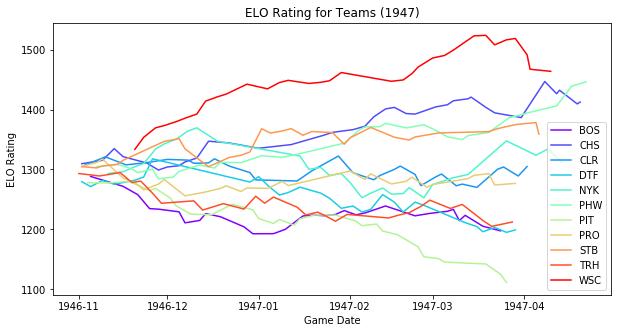

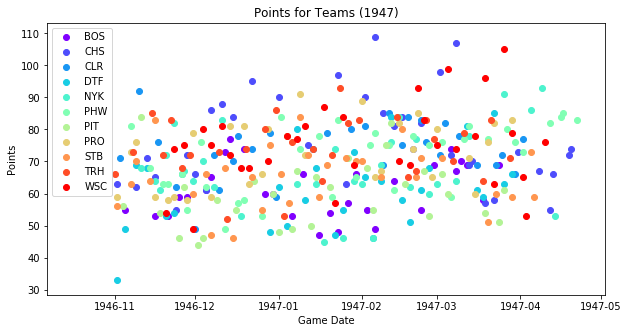

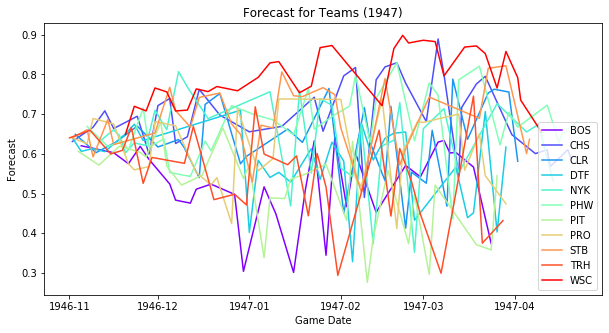

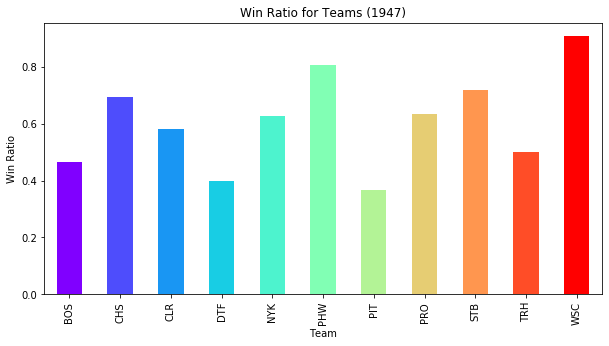

In [101]:
import matplotlib.pylab as plt
import matplotlib.cm as cm

keys = [("elo_n", "ELO Rating"), ("pts", "Points"), ("forecast", "Forecast")]

year = 1947
year_data = nba_df.loc[nba_df["year_id"] == year]
colors = cm.rainbow(np.linspace(0, 1, year_data["team_id"].unique().size))

for (k, v) in keys:
    plt.figure(figsize=(10, 5))

    data = year_data.groupby(["team_id"])\
        .apply(lambda row: np.array(list(zip(row["date_game"], row[k], row["team_id"]))))
    data = np.array(list(data))

    i = 0
    for d in data:
        if v == "Points":
            plt.scatter(d[:,0], d[:,1], color=colors[i], label=d[:,2][0])
        else:
            plt.plot(d[:,0], d[:,1], color=colors[i], label=d[:,2][0])
        i += 1
    plt.title("%s for Teams (%s)" % (v, year))
    plt.xlabel("Game Date")
    plt.ylabel(v)
    plt.legend()

    plt.show()

#####

data = year_data.groupby(["team_id"]).head(1)[["team_id", "win_ratio"]].sort_values(by="team_id")

data.plot.bar(x="team_id", y="win_ratio", legend=False, figsize=(10, 5), color=colors)
plt.title("Win Ratio for Teams (%s)" % year)
plt.xlabel("Team")
plt.ylabel("Win Ratio")
plt.show()

It looks like a team's `ELO` rating is the best indicator for regression, so let's play around a bit with that and see if we can get some good results: